In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "3"

In [2]:
import pandas as pd

df = pd.read_csv('sample/ubuntu_context_1000.csv')


In [3]:
df

,Unnamed: 0,dialogueID,date,from,to,text
0,100015,12077.tsv,2005-01-01T13:08:00.000Z,anir,NaN,hope we will get something better linux in the...
1,100016,12077.tsv,2005-01-01T13:09:00.000Z,anir,NaN,now Window is coming with LongHorn... its great..
2,100017,12077.tsv,2005-01-01T13:10:00.000Z,anir,NaN,i have just tried transformation package in XP...
3,100018,12077.tsv,2005-01-01T13:10:00.000Z,anir,NaN,now the ball is in your court LINUX..
4,100019,12077.tsv,2005-01-01T13:11:00.000Z,anir,NaN,what happened guys.. say something
...,...,...,...,...,...,...
982,8944250,12317.tsv,2008-12-17T02:58:00.000Z,Aberation,djbushdio,nothing happens when I directly open cdrom0
983,8944251,12317.tsv,2008-12-17T02:59:00.000Z,Aberation,djbushdio,WAIT! I got something when opening cdrom...but...
984,8944252,12317.tsv,2008-12-17T03:01:00.000Z,Aberation,djbushdio,"logos are fine, but the menu has many colored ..."
985,8944253,12317.tsv,2008-12-17T03:02:00.000Z,Aberation,djbushdio,same thing when I try to read the movie...


## Preprocess the Data

In [4]:
def build_prompt_response_pairs(df):
    grouped = df.groupby("dialogueID")
    conversations = []
    for _, group in grouped:
        turns = group.sort_values("date")["text"].dropna().tolist()
        for i in range(len(turns) - 1):
            conversations.append({
                "text": f"### Prompt:\n{turns[i]}\n### Response:\n{turns[i + 1]}"
            })
    return pd.DataFrame(conversations)

In [5]:
processed_df = build_prompt_response_pairs(df)
processed_df

,text
0,### Prompt:\nAnyone here that got experience w...
1,### Prompt:\n- I have payed with the ati drive...
2,"### Prompt:\n- my card is a radeon 9550, for r..."
3,### Prompt:\n: what kind of clues??\n### Respo...
4,### Prompt:\n- first off fglrx the open sourc...
...,...
958,### Prompt:\nnot implementing a database :/\n#...
959,### Prompt:\nHello...\n### Response:\nA small ...
960,### Prompt:\nA small question: What would caus...
961,"### Prompt:\nFunny thing is, Win7 and XP insta..."


In [6]:
from datasets import Dataset
dataset = Dataset.from_pandas(processed_df)
dataset

Dataset({
    features: ['text'],
    num_rows: 963
})

In [7]:
SEED = 69
dataset = dataset.train_test_split(test_size=0.3, seed=SEED)    
val_test_split = dataset['test'].train_test_split(test_size=0.5, seed=SEED)
dataset['validation'] = val_test_split['train']
dataset['test'] = val_test_split['test']

In [8]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'{device}:torch.cuda.current_device(): {torch.cuda.get_device_name()}')

cuda:torch.cuda.current_device(): NVIDIA GeForce RTX 2080 Ti


In [9]:
from transformers import AutoTokenizer

MODEL_NAME = 'EleutherAI/gpt-neo-1.3B'
MAX_LENGTH = 128

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
tokenizer.pad_token = tokenizer.eos_token

def tokenize(example):
    tokens = tokenizer(
        example["text"],
        truncation=True,
        padding="max_length",
        max_length=MAX_LENGTH
    )
    tokens["labels"] = tokens["input_ids"].copy()
    return tokens

#### Set all data splits to torch format

In [10]:
tokenized_dataset = dataset.map(tokenize, batched=True)

for split in ['train', 'validation', 'test']:
    tokenized_dataset[split].set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

Map:   0%|          | 0/674 [00:00<?, ? examples/s]

Map:   0%|          | 0/145 [00:00<?, ? examples/s]

Map:   0%|          | 0/144 [00:00<?, ? examples/s]

## Load Model + LoRA

In [11]:
from transformers import BitsAndBytesConfig, AutoModelForCausalLM

bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4"
)

model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    # device_map=f"cuda:{torch.cuda.current_device()}",
    torch_dtype=torch.float16
)

from peft import prepare_model_for_kbit_training, get_peft_model, LoraConfig

# model.gradient_checkpointing_enable()
model = prepare_model_for_kbit_training(model)

# config for mistral and neo-gpt
lora_config = LoraConfig(
    r=8,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)

In [12]:
print(model.is_gradient_checkpointing)

True


In [13]:
model.gradient_checkpointing_disable() 
print(model.is_gradient_checkpointing) 

False


### Training args and Trainer

In [14]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./models/gpt-neo",
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    num_train_epochs=3,
    fp16=False,
    logging_dir="./logs",
    logging_steps=100,
    logging_strategy='steps',
    save_strategy="epoch",
    gradient_accumulation_steps=1,
    evaluation_strategy="steps",
    eval_steps=100,
    report_to=None
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"]
)

/home/jupyter-st124974/.local/lib/python3.12/site-packages/transformers/training_args.py:1594: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [15]:
trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: st124974 (binit-ait) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss,Validation Loss
100,2.142100,0.923598
200,0.881700,0.830296
300,0.856300,0.816970
400,0.817100,0.810600
500,0.821400,0.808871


TrainOutput(global_step=507, training_loss=1.1005783758219883, metrics={'train_runtime': 225.2219, 'train_samples_per_second': 8.978, 'train_steps_per_second': 2.251, 'total_flos': 1879047690780672.0, 'train_loss': 1.1005783758219883, 'epoch': 3.0})

In [16]:
trainer.state.log_history

[{'loss': 2.1421,
  'grad_norm': 0.883268415927887,
  'learning_rate': 4.0138067061143986e-05,
  'epoch': 0.591715976331361,
  'step': 100},
 {'eval_loss': 0.9235981702804565,
  'eval_runtime': 6.2715,
  'eval_samples_per_second': 22.961,
  'eval_steps_per_second': 5.74,
  'epoch': 0.591715976331361,
  'step': 100},
 {'loss': 0.8817,
  'grad_norm': 0.6994218826293945,
  'learning_rate': 3.027613412228797e-05,
  'epoch': 1.183431952662722,
  'step': 200},
 {'eval_loss': 0.8302962779998779,
  'eval_runtime': 6.3061,
  'eval_samples_per_second': 22.835,
  'eval_steps_per_second': 5.709,
  'epoch': 1.183431952662722,
  'step': 200},
 {'loss': 0.8563,
  'grad_norm': 0.5275363326072693,
  'learning_rate': 2.0414201183431952e-05,
  'epoch': 1.7751479289940828,
  'step': 300},
 {'eval_loss': 0.8169703483581543,
  'eval_runtime': 6.3802,
  'eval_samples_per_second': 22.57,
  'eval_steps_per_second': 5.642,
  'epoch': 1.7751479289940828,
  'step': 300},
 {'loss': 0.8171,
  'grad_norm': 0.5999659

In [18]:
from matplotlib import pyplot as plt
import seaborn as sns

log_df = pd.DataFrame(trainer.state.log_history)
log_df

,loss,grad_norm,learning_rate,epoch,step,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second,train_runtime,train_samples_per_second,train_steps_per_second,total_flos,train_loss
0,2.1421,0.883268,4.013807e-05,0.591716,100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,0.591716,100,0.923598,6.2715,22.961,5.740,NaN,NaN,NaN,NaN,NaN
2,0.8817,0.699422,3.027613e-05,1.183432,200,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,1.183432,200,0.830296,6.3061,22.835,5.709,NaN,NaN,NaN,NaN,NaN
4,0.8563,0.527536,2.041420e-05,1.775148,300,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,1.775148,300,0.816970,6.3802,22.570,5.642,NaN,NaN,NaN,NaN,NaN
6,0.8171,0.599966,1.055227e-05,2.366864,400,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,2.366864,400,0.810600,6.3746,22.590,5.647,NaN,NaN,NaN,NaN,NaN
8,0.8214,0.771011,6.903353e-07,2.958580,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,2.958580,500,0.808871,6.3911,22.531,5.633,NaN,NaN,NaN,NaN,NaN


In [19]:
loss_df = log_df[["step", "loss"]].dropna().copy()
loss_df["type"] = "train"
loss_df

,step,loss,type
0,100,2.1421,train
2,200,0.8817,train
4,300,0.8563,train
6,400,0.8171,train
8,500,0.8214,train


In [20]:
eval_loss_df = log_df[["step", "eval_loss"]].dropna().copy()
eval_loss_df = eval_loss_df.rename(columns={"eval_loss": "loss"})
eval_loss_df["type"] = "eval"
eval_loss_df

,step,loss,type
1,100,0.923598,eval
3,200,0.830296,eval
5,300,0.816970,eval
7,400,0.810600,eval
9,500,0.808871,eval


In [21]:
plot_df = pd.concat([loss_df, eval_loss_df])
plot_df

,step,loss,type
0,100,2.142100,train
2,200,0.881700,train
4,300,0.856300,train
6,400,0.817100,train
8,500,0.821400,train
1,100,0.923598,eval
3,200,0.830296,eval
5,300,0.816970,eval
7,400,0.810600,eval
9,500,0.808871,eval


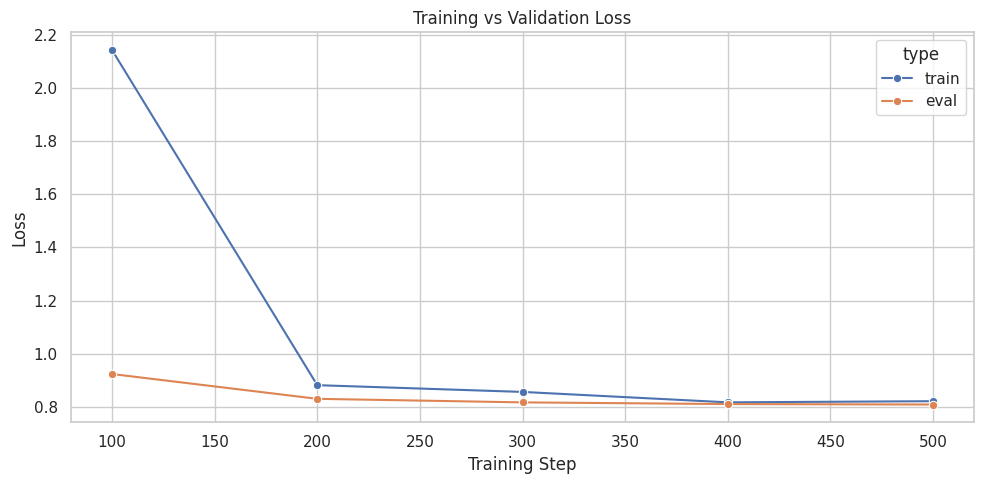

In [23]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 5))
sns.lineplot(data=plot_df, x="step", y="loss", hue="type", marker="o")
plt.title("Training vs Validation Loss")
plt.xlabel("Training Step")
plt.ylabel("Loss")
plt.tight_layout()
plt.show()

In [24]:
model.save_pretrained("models/gpt-neo-lora-checkpoint-final")
tokenizer.save_pretrained("models/gpt-neo-lora-checkpoint-final")

('models/gpt-neo-lora-checkpoint-final/tokenizer_config.json',
 'models/gpt-neo-lora-checkpoint-final/special_tokens_map.json',
 'models/gpt-neo-lora-checkpoint-final/vocab.json',
 'models/gpt-neo-lora-checkpoint-final/merges.txt',
 'models/gpt-neo-lora-checkpoint-final/added_tokens.json',
 'models/gpt-neo-lora-checkpoint-final/tokenizer.json')